In [1]:
# import packages
import numpy as np
import scipy.io as sio
import matplotlib
import matplotlib.pyplot as plt
from numpy.matlib import repmat
from sklearn.preprocessing import normalize
import pandas as pd
import os
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


In [2]:
def load_images_from_folder(folder_path, target_size=(200, 200), color_mode='RGB'):
    images = []
    original_images = []  
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        try:
            img = Image.open(file_path).convert(color_mode)  
            img_resized = img.resize(target_size)  
            images.append(np.array(img_resized).flatten())  
            original_images.append(np.array(img_resized)) 
        except Exception as e:
            print(f"Error loading image {filename}: {e}")
    return np.array(images), np.array(original_images) 


In [3]:
def normalize_channels(images):
    n_samples, flattened_size = images.shape 
    side_length = int(np.sqrt(flattened_size // 3))  
    images_reshaped = images.reshape((n_samples, side_length, side_length, 3)) 
    
    height, width = images_reshaped.shape[1], images_reshaped.shape[2]

    r_channel = images_reshaped[..., 0]
    g_channel = images_reshaped[..., 1]
    b_channel = images_reshaped[..., 2]

    r_channel = r_channel / 255.0
    g_channel = g_channel / 255.0
    b_channel = b_channel / 255.0

    return r_channel, g_channel, b_channel, height, width


In [4]:
def perform_pca_on_channel(channel_data, n_components):
    n_samples, height, width = channel_data.shape 
    channel_flattened = channel_data.reshape((n_samples, height*width))  
    
    channel_mean = np.mean(channel_flattened, axis=0)
    channel_centered = channel_flattened - channel_mean

    pca = PCA(n_components=n_components)
    Z = pca.fit_transform(channel_centered) 
    principal_components = pca.components_

    return Z, principal_components, channel_mean


In [5]:
def reconstruct_channel(Z, principal_components, channel_mean, height, width):
    reconstructed_flattened = np.dot(Z, principal_components) + channel_mean

    reconstructed_channel = reconstructed_flattened.reshape((-1, height, width))

    return reconstructed_channel


In [6]:
def combine_channels(r, g, b):
    reconstruct_rgb = np.stack((r, g, b), axis=1).transpose(0, 2, 3, 1)

    return reconstruct_rgb


In [7]:
folder_path = "simpsons_background_removed"
simpsons_rgb, simpsons_original_rgb = load_images_from_folder(folder_path, target_size=(200, 200))

r_channel, g_channel, b_channel, height, width = normalize_channels(simpsons_rgb)

n_components = 47 #(make bigger for shraper image, but it will run slower)

r_Z, r_principal_components, r_channel_mean = perform_pca_on_channel(r_channel, n_components)
g_Z, g_principal_components, g_channel_mean = perform_pca_on_channel(g_channel, n_components)
b_Z, b_principal_components, b_channel_mean = perform_pca_on_channel(b_channel, n_components)

r_reconstructed = reconstruct_channel(r_Z, r_principal_components, r_channel_mean, height, width)
g_reconstructed = reconstruct_channel(g_Z, g_principal_components, g_channel_mean, height, width)
b_reconstructed = reconstruct_channel(b_Z, b_principal_components, b_channel_mean, height, width)

reconstructed_rgb = combine_channels(r_reconstructed, g_reconstructed, b_reconstructed)


Error loading image .DS_Store: cannot identify image file '/Users/mariabalderas/Desktop/COGS118B/FA24_COGS118B_Final/ppl_looking_one_direction/.DS_Store'


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


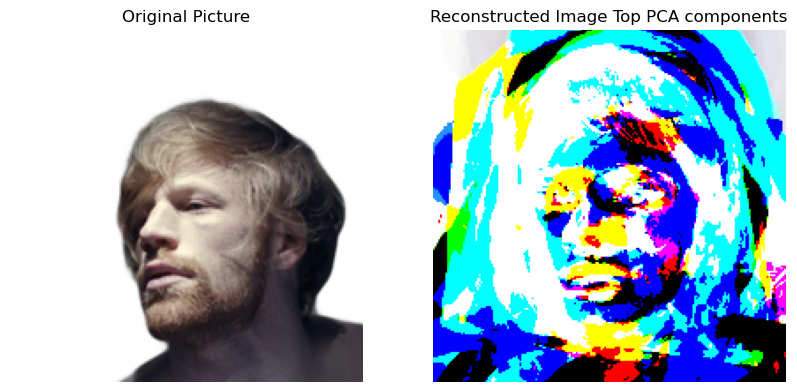

In [8]:
human_faces, human_faces_og = load_images_from_folder('ppl_looking_one_direction', target_size=(200, 200))

r_channel_humface, g_channel_humface, b_channel_humface, height_humface, width_humface = normalize_channels(human_faces)

r_mean_sub = (r_channel_humface.reshape(r_channel.shape[0], r_channel.shape[1]*r_channel.shape[2]) - r_channel_mean)
g_mean_sub = (g_channel_humface.reshape(g_channel.shape[0], g_channel.shape[1]*g_channel.shape[2]) - g_channel_mean)
b_mean_sub = (b_channel_humface.reshape(b_channel.shape[0], b_channel.shape[1]*b_channel.shape[2]) - b_channel_mean)

top_k = 14
r_Z_top = r_Z[:, :top_k]
g_Z_top = g_Z[:, :top_k]
b_Z_top = b_Z[:, :top_k]

r_Z_faces_top = r_Z_top.T.dot(r_mean_sub)
g_Z_faces_top = g_Z_top.T.dot(g_mean_sub)
b_Z_faces_top = b_Z_top.T.dot(b_mean_sub)


r_reconstructed_hum_top = reconstruct_channel(r_Z_top, r_Z_faces_top, r_channel_mean, height, width)
g_reconstructed_hum_top = reconstruct_channel(g_Z_top, g_Z_faces_top, g_channel_mean, height, width)
b_reconstructed_hum_top = reconstruct_channel(b_Z_top, b_Z_faces_top, b_channel_mean, height, width)

reconstructed_rgb_hum_top = combine_channels(r_reconstructed_hum_top, g_reconstructed_hum_top, b_reconstructed_hum_top)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(human_faces_og[20])
axes[0].set_title("Original Picture")
axes[0].axis('off')

plt.imshow(reconstructed_rgb_hum_top[20])
plt.title("Reconstructed Image Top PCA components")
plt.axis('off')
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


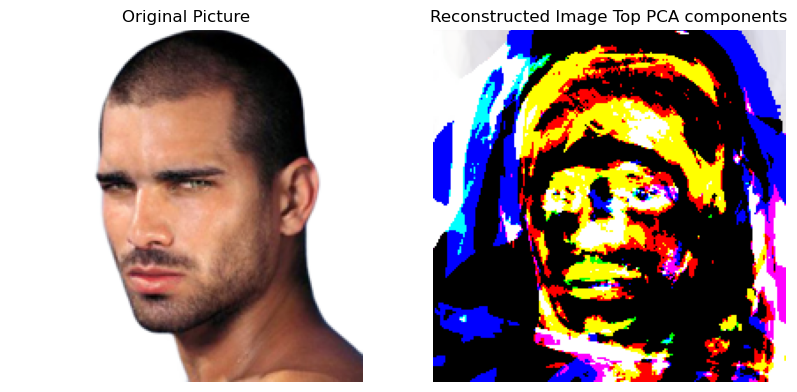

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(human_faces_og[30])
axes[0].set_title("Original Picture")
axes[0].axis('off')

plt.imshow(reconstructed_rgb_hum_top[30])
plt.title("Reconstructed Image Top PCA components")
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


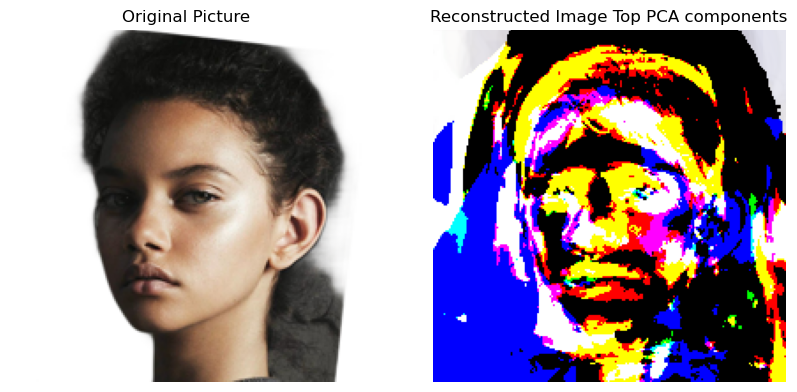

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(human_faces_og[39])
axes[0].set_title("Original Picture")
axes[0].axis('off')

plt.imshow(reconstructed_rgb_hum_top[39])
plt.title("Reconstructed Image Top PCA components")
plt.axis('off')
plt.show()